# **Siminilarities**

## **Imports**

In [13]:
#python -m spacy download de_core_news_sm
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import csv

from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora, similarities
from gensim.matutils import sparse2full
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display
from sklearn.metrics.pairwise import cosine_similarity

## **Information**

Prefer spacy instead of nltk because it's faster and we want to compute large texts. Lemmatization and Stemming are redundand and different aproaches. They normaly are not used together. Decided for Lemmatizing because its integrated into spacy module:


Sources:
- Text Similarity Measures in News Articles by Vector Space Model Using NLP (https://link.springer.com/article/10.1007/s40031-020-00501-5)
- Compare documents similarity using Python | NLP (https://dev.to/thedevtimeline/compare-documents-similarity-using-python-nlp-4odp)
- What is gensim.similarities.MatrixSimilarity() function? (https://www.educative.io/answers/what-is-gensimsimilaritiesmatrixsimilarity-function)

In [14]:
sp = spacy.load("de_core_news_sm")

# **Read Party txt Files**

In [15]:

party_txt = [
    "../python/data_preprocessing/output/CDU-CSU.txt",
    "../python/data_preprocessing/output/SPD.txt",
    "../python/data_preprocessing/output/DIE_GRUENEN.txt",
    "../python/data_preprocessing/output/AFD.txt",
    "../python/data_preprocessing/output/DIE_LINKE.txt",
    "../python/data_preprocessing/output/FDP.txt"
]

party_names = [
    "CDU & CSU",
    "SPD",
    "B90 / Die Grünen",
    "AFD",
    "Die Linke",
    "FDP"
]

# Read in party txt files and convert them to string representation
party_docs = []

for p in party_txt:
    with open(p, "r", encoding="utf-8") as file:
        txt_path = file.read()

    party_docs.append(txt_path)

# **Preprocessing**

## **Preprocessing Class**

In [16]:
class TextPreprocessor:
    def __init__(self):
        self.nlp = spacy.load("de_core_news_sm")
    
    def tokenize_documents(self, documents):
        tokenized_docs = []
        for doc in documents:
            doc_tokens = self.nlp(doc)
            tokenized_tokens = [token.text for token in doc_tokens]
            tokenized_docs.append(tokenized_tokens)
        return tokenized_docs
    
    def remove_tags(self, tokenized_docs):
        without_tag_docs = []
        
        for doc_tokens in tokenized_docs:
            cleaned_tokens = [token.strip().replace('\n', '') for token in doc_tokens if token.strip().replace('\n', '') not in ['\n', '']]
            without_tag_docs.append(cleaned_tokens)
        return without_tag_docs
    
    def lemmatize_documents(self, tokenized_docs):
        lemmatized_docs = []
        for doc_tokens in tokenized_docs:
            lemmatized_tokens = [token.lemma_ for token in self.nlp(' '.join(doc_tokens))]
            lemmatized_docs.append(lemmatized_tokens)
        return lemmatized_docs
    
    def remove_stopwords_punctuations_numbers(self, lemmatized_docs):
        clean_docs = []
        for lemmatized_tokens in lemmatized_docs:
            lemmatized_tokens_no_stopwords = [token for token in lemmatized_tokens if not self.nlp.vocab[token].is_stop]
            lemmatized_tokens_no_punct = [token for token in lemmatized_tokens_no_stopwords if not self.nlp.vocab[token].is_punct]
            lemmatized_tokens_no_nums = [token for token in lemmatized_tokens_no_punct if not self.nlp.vocab[token].like_num]
            clean_docs.append(lemmatized_tokens_no_nums)
        return clean_docs

preprocessor = TextPreprocessor()

# Tokenization
tokenized = preprocessor.tokenize_documents(party_docs)

# Clear Tags
tag_cleared = preprocessor.remove_tags(tokenized)

# Lemmatization
lemmatized = preprocessor.lemmatize_documents(tag_cleared)

# Removing Stopwords, Punctuation, and Numbers
cleaned = preprocessor.remove_stopwords_punctuations_numbers(lemmatized)


# **Representation Scheme**

## **Bag of Words**

In [17]:
def create_bow_representation(preprocessed_docs):
    dictionary = corpora.Dictionary(preprocessed_docs)
    bow_corpus = [dictionary.doc2bow(doc) for doc in preprocessed_docs]
    return dictionary, bow_corpus

bow_dictionary, bow_corpus = create_bow_representation(cleaned)

# Display bow representation
print("\nBag-of-Words Representation:")
num_terms = len(bow_dictionary)
bow_matrix = [sparse2full(doc, num_terms) for doc in bow_corpus]
bow_df = pd.DataFrame(bow_matrix, columns=[bow_dictionary[i] for i in range(num_terms)])

display(bow_df)

print(bow_dictionary)
#print(bow_corpus)


Bag-of-Words Representation:


,2%-Ziel,20er,Abhängigkeit,Abkommen,Abrüs,Abrüstung,Abschreckung,Abstimmung,Allseitigen,Alltag,...,Übernahme,Übertragung,öffentlich-privat,überall,überweisen,überzeugen,überﬂüssig,€,ﬁnanziell,ﬁnanzpolitisch
0,1.0,1.0,2.0,1.0,1.0,2.0,3.0,3.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,2.0,2.0,8.0,1.0,2.0


Dictionary<4036 unique tokens: ['2%-Ziel', '20er', 'Abhängigkeit', 'Abkommen', 'Abrüs']...>


## **TF-IDF**

In [18]:
def create_tfidf_representation(preprocessed_docs):
    # Joining tokenized documents to form a list of strings
    tokenized_texts = [' '.join(doc) for doc in preprocessed_docs]
    
    # Creating TF-IDF vectorizer and fitting on the tokenized documents
    ifidf_vectorizer = TfidfVectorizer()
    tfidf_representation = ifidf_vectorizer.fit_transform(tokenized_texts)
    
    feature_names = ifidf_vectorizer.get_feature_names_out()
    
    return tfidf_representation, feature_names

tfidf_corpus, tfidf_dictionary = create_tfidf_representation(cleaned)

tfidf_df = pd.DataFrame(tfidf_corpus.toarray(), columns=tfidf_dictionary)

# Display the TF-IDF DataFrame
print("\nTF-IDF Representation:")
display(tfidf_df)


TF-IDF Representation:


,043,18,19,1bereit,1bundestagswahlprogramm,20,2020durchschnittliche,2020lohnsteuer,2021,2021ist,...,ürg,ﬁnanziell,ﬁnanzieren,ﬁnanziert,ﬁnanzpolitisch,ﬁnden,ﬁt,ﬂankieren,ﬂießen,ﬂächendeckend
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.018734,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.073966,0.073966,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.027542,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.015331,0.015331,0.000000,0.037714,0.012571,0.015331,0.015331,0.012571
5,0.011306,0.011306,0.011306,0.000000,0.000000,0.000000,0.011306,0.011306,0.011306,0.011306,...,0.000000,0.011306,0.000000,0.000000,0.022611,0.009271,0.027812,0.000000,0.000000,0.009271


## **Doc2Vec**

Doc2Vec ist sehr anfällig auf unterschiedlich lange Dokumente

In [19]:
def create_doc2vec_representation(preprocessed_docs):
    tagged_data = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(preprocessed_docs)]

    # hyperparameters should be optimized    
    # Train Doc2Vec model
    model = Doc2Vec(vector_size=20, alpha=0.025, min_alpha=0.0025, min_count=2, epochs=100)
    model.build_vocab(tagged_data)
    
    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

    doc2vec_representation = [model.infer_vector(doc.words) for doc in tagged_data]
    
    return doc2vec_representation

doc2vec_corpus = create_doc2vec_representation(cleaned)

# Convert Doc2Vec corpus to a DataFrame
doc2vec_df = pd.DataFrame(doc2vec_corpus)

# Display the Doc2Vec DataFrame
print("\nDoc2Vec Representation:")
display(doc2vec_df)


Doc2Vec Representation:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-5.235388,-7.895388,-14.667959,9.383611,7.811940,-0.238078,-7.502172,2.630028,-14.500631,-1.814749,-5.992255,2.935203,-2.847084,-5.600086,-4.744724,-8.624313,4.914009,12.043169,-13.507874,-12.195882
1,-11.137623,7.776785,-8.656810,11.509438,-1.820450,-6.319900,-10.038606,-10.451309,-1.150893,-3.347126,15.454029,11.108823,-5.609262,-1.565929,0.915561,-6.770005,-2.622611,-12.299832,-6.014297,-3.873407
2,-12.546206,-13.864424,-0.742622,-5.663690,-3.110567,-11.200537,-12.617551,1.031616,6.295333,-12.304533,8.456088,-2.747754,-6.723855,-7.184594,3.366000,3.195722,-5.167611,5.134822,-14.413989,3.657925
3,-8.212214,7.771205,-3.363884,0.195823,-2.147666,-11.574131,4.114733,11.240316,-16.582542,-9.427076,1.627409,-3.167730,-9.247739,-21.435562,-3.836609,-11.641878,-11.540294,-0.831968,-9.703060,2.242585
4,0.931117,1.585377,-19.982185,3.253267,6.567860,-3.172356,-0.739970,3.298198,8.704114,1.147945,-4.707982,0.385881,-14.502999,-22.517008,3.708462,5.675596,-3.765851,-3.777327,0.817478,3.338460
5,-8.461905,-4.903175,-7.871230,12.690117,-8.738581,2.701431,-2.186186,13.157209,-1.077378,9.183823,3.384143,-8.875525,1.650942,-4.551477,11.176114,-15.023301,-6.211751,5.429831,-0.793175,4.437547


# **Similarity Measures**

### Visualization Functions

In [20]:
def viz_sim(scores, title="no title"):

    df = pd.DataFrame(scores, columns=party_names, index=party_names)

    plt.figure(figsize=(10, 8))
    sns.heatmap(df, annot=True, cmap='cividis', fmt='.2f')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def viz_party_to_others(scores, party_names=party_names):
    colors = ['black', 'red', 'green', 'blue', 'pink', 'yellow']
    
    num_parties = len(party_names)
    num_plots = (num_parties // 3) + (num_parties % 3 > 0)

    for i in range(num_plots):
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))

        for j in range(3):
            idx = i * 3 + j
            if idx < num_parties:
                scores_copy = scores.copy()
                scores_copy[idx][idx] = 0

                percentages = (scores_copy[idx]) * 100

                axs[j].bar(party_names, percentages, color=[colors[k - 1] for k in range(1, len(party_names) + 1)])
                axs[j].set_xlabel('Parties')
                axs[j].set_ylabel('Percentage')
                axs[j].set_ylim(0, 100)

                axs[j].set_title(f'{party_names[idx]} most similar manifestos')

                for k, percentage in enumerate(percentages):
                    axs[j].text(k, percentage + 1, f'{percentage:.2f}%', ha='center')

                axs[j].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

def top_coalitions(scores, party_names=party_names):
    num_parties = len(party_names)
    all_combinations = list(itertools.combinations(range(num_parties), 3))  # All unique combinations of three parties

    coalition_scores = []
    for coalition in all_combinations:
        coalition_score = sum(scores[i, j] for i in coalition for j in coalition if i != j)
        coalition_scores.append({
            'coalition': coalition,
            'score': coalition_score
        })

    # Sort the coalitions based on their scores in descending order
    sorted_coalitions = sorted(coalition_scores, key=lambda x: x['score'], reverse=True)

    # Display the top three coalitions with their scores
    top_coalitions_final = sorted_coalitions[:5]
    for idx, coalition_data in enumerate(top_coalitions_final, 1):
        coalition_party_names = [party_names[i] for i in coalition_data['coalition']]
        print(f"Top {idx} Coalition: {', '.join(coalition_party_names)} Score: {coalition_data['score']}")

    return


## **Cosine**

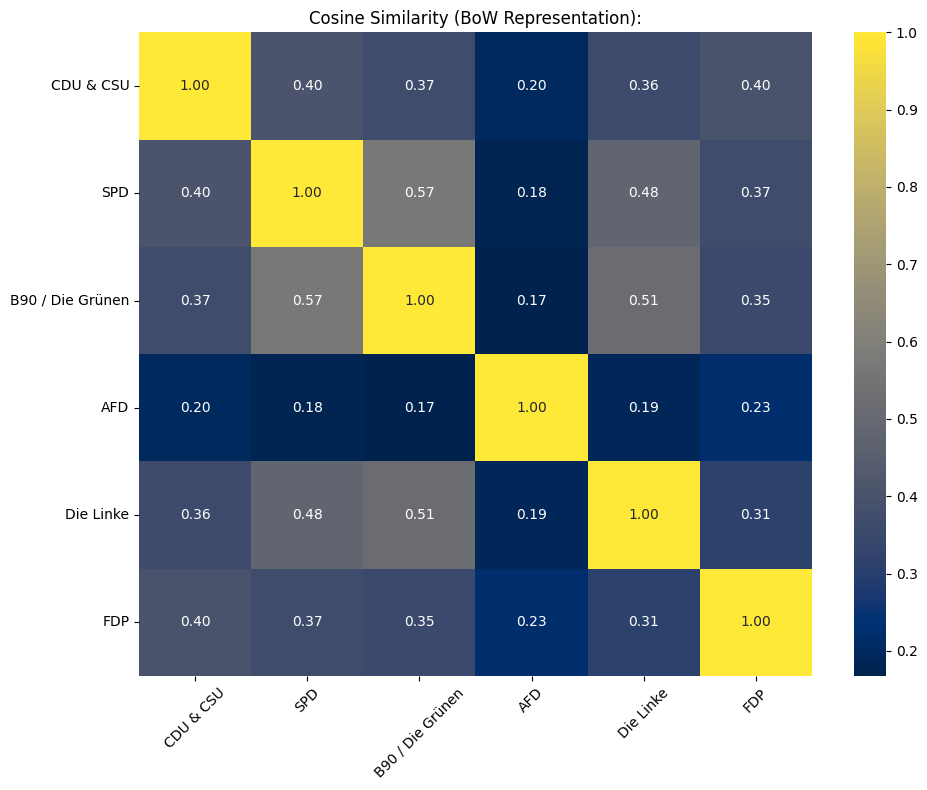

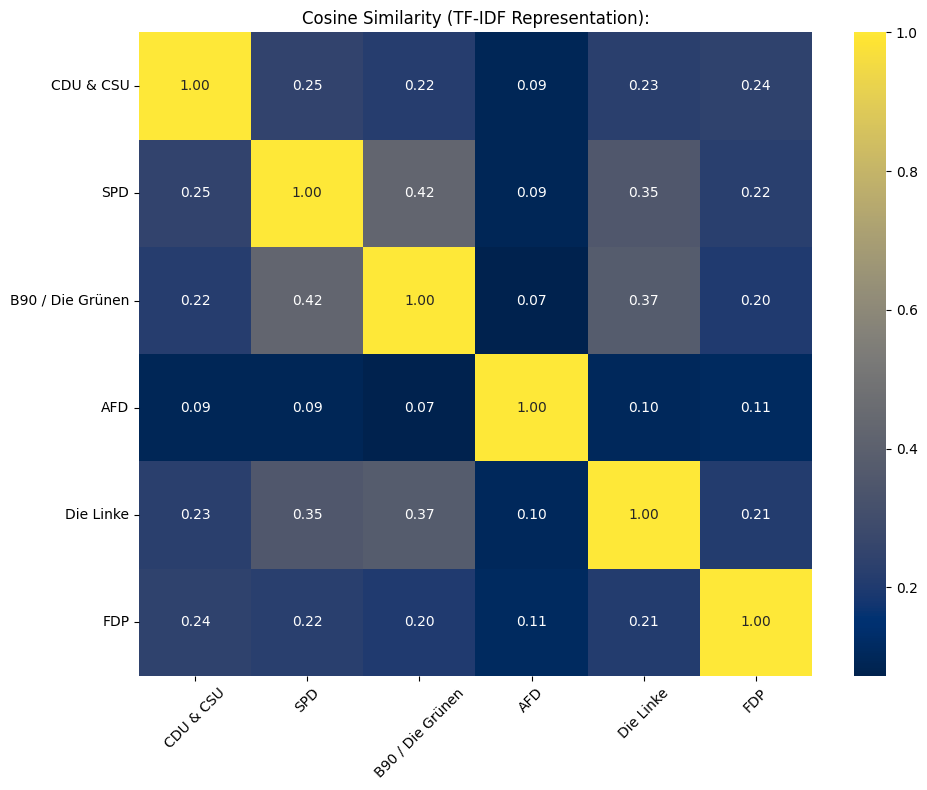

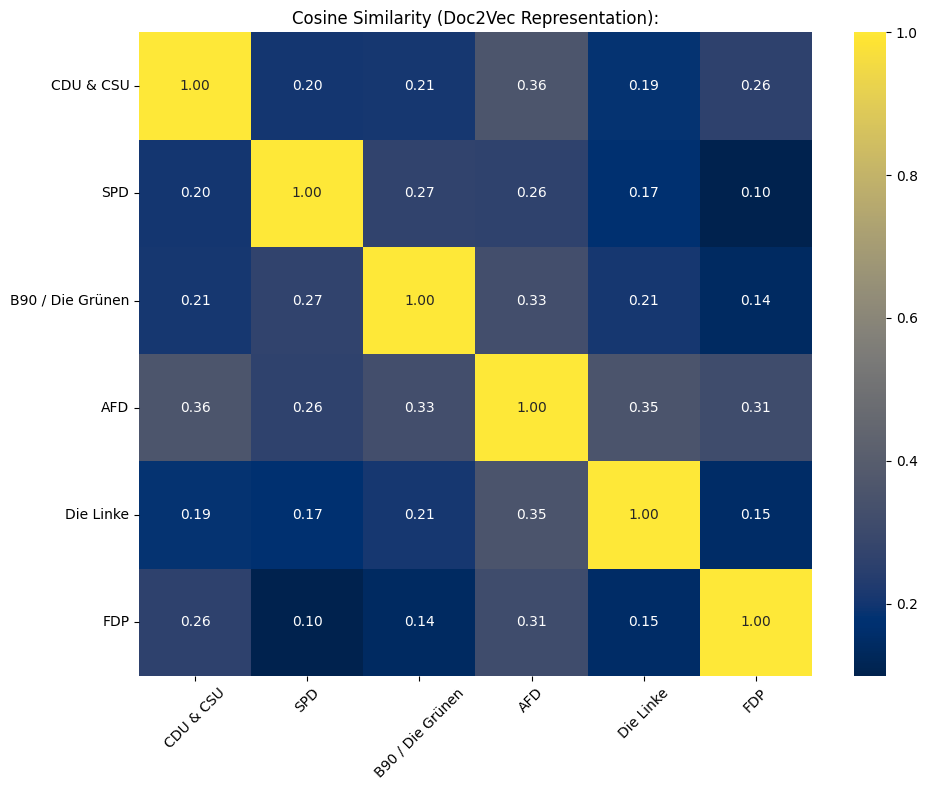

In [21]:
def calculate_cosine_similarity(corpus, similarity_type='bow'):
    if similarity_type == 'bow':
        index = similarities.MatrixSimilarity(corpus) #calculates automaticly cosine similarity
    elif similarity_type == 'tfidf' or similarity_type == 'doc2vec':
        index = cosine_similarity(corpus)
    else:
        raise ValueError("Invalid similarity_type. Choose 'bow', 'doc2vec' or 'tfidf'.")
    
    return index

bow_similarity_index = calculate_cosine_similarity(bow_corpus, similarity_type='bow')
viz_sim(bow_similarity_index, "Cosine Similarity (BoW Representation):")

tfidf_similarity_index = calculate_cosine_similarity(tfidf_corpus, similarity_type='tfidf')
viz_sim(tfidf_similarity_index, 'Cosine Similarity (TF-IDF Representation):')

doc2vec_similarity_index = calculate_cosine_similarity(doc2vec_corpus, similarity_type='doc2vec')
viz_sim(doc2vec_similarity_index, 'Cosine Similarity (Doc2Vec Representation):')


## **Weighted Cosine Similarity**

experiment with similar weighted BoW, TF-IDF and Doc2Vec representation

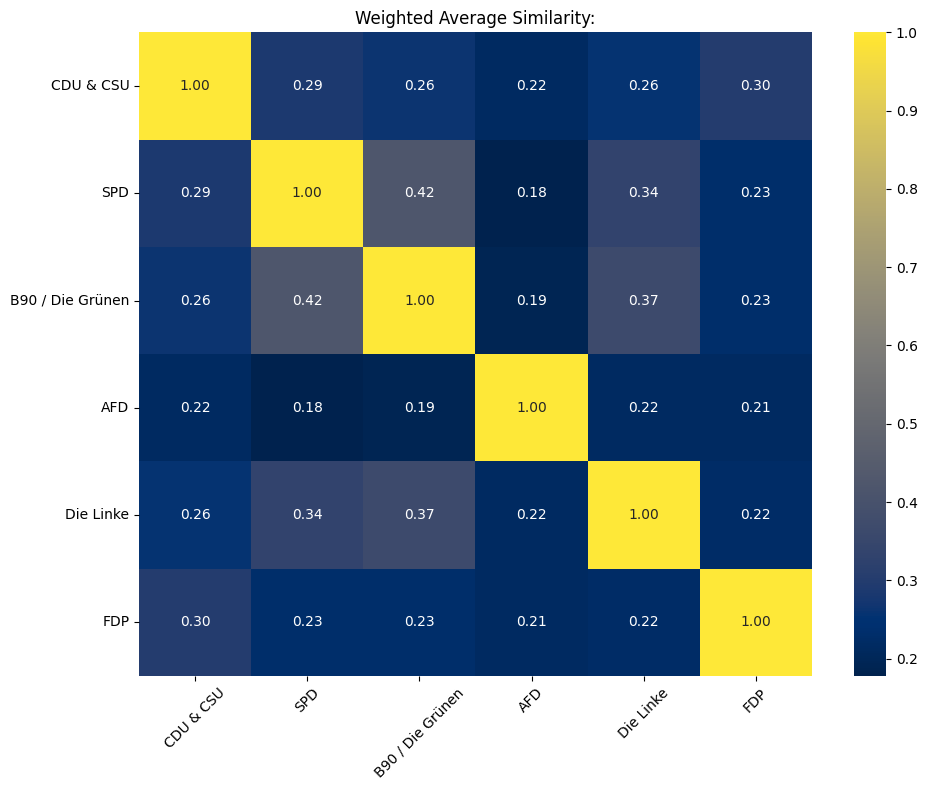

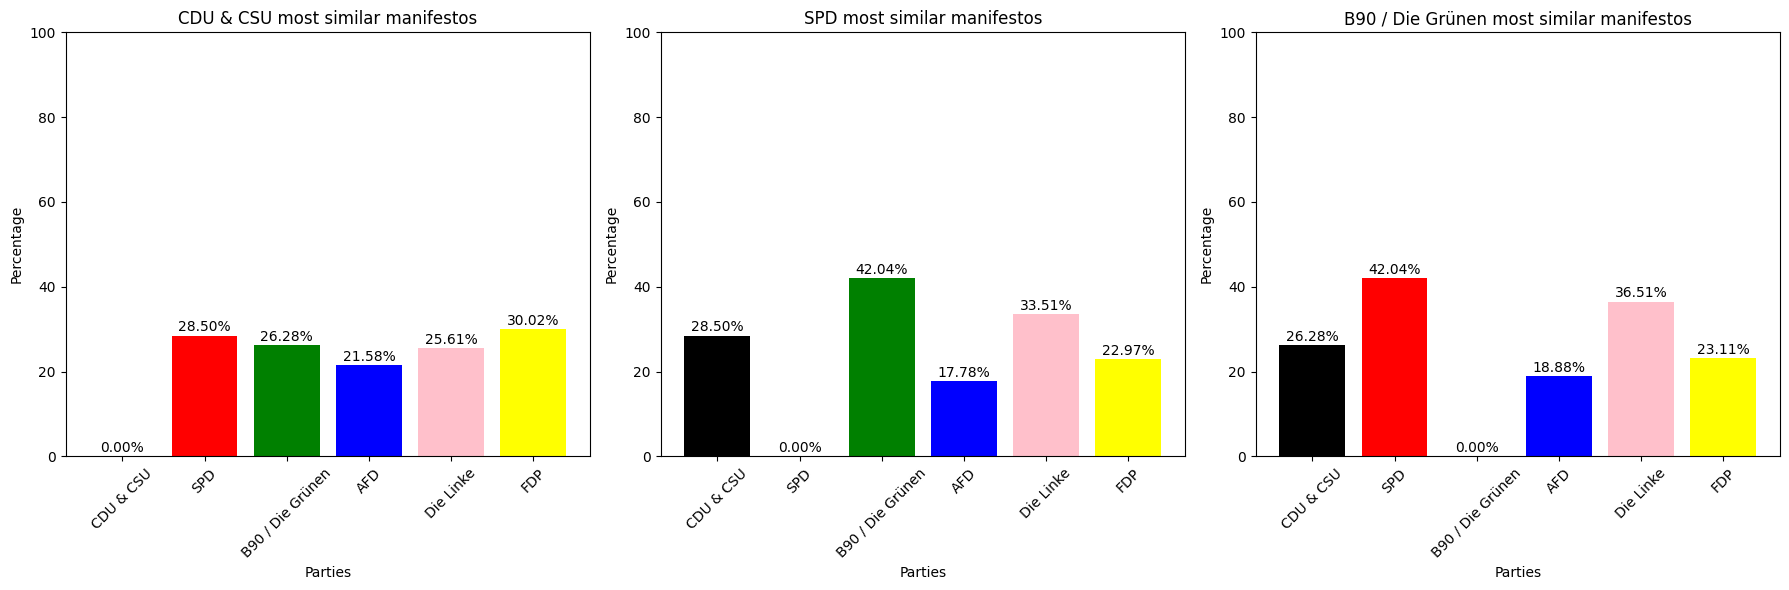

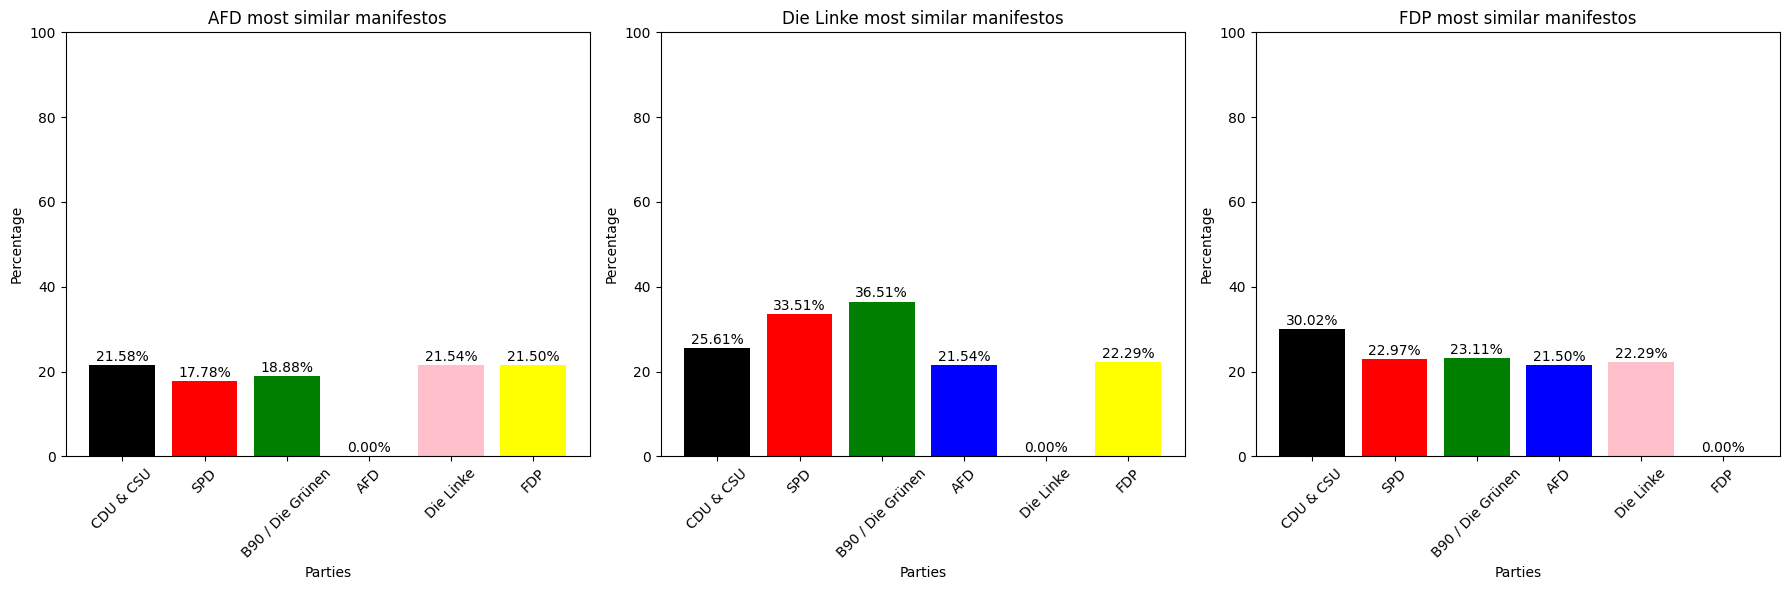

Top 1 Coalition: SPD, B90 / Die Grünen, Die Linke Score: 2.241037954921585
Top 2 Coalition: CDU & CSU, SPD, B90 / Die Grünen Score: 1.9364799514414672
Top 3 Coalition: CDU & CSU, B90 / Die Grünen, Die Linke Score: 1.767879242039291
Top 4 Coalition: SPD, B90 / Die Grünen, FDP Score: 1.7623803485819238
Top 5 Coalition: CDU & CSU, SPD, Die Linke Score: 1.7524267489077587


In [22]:
weights = [0.33, 0.33, 0.33]

# MatrixSimilarity-Objekte in NumPy-Arrays
bow_similarity_array = np.array(list(bow_similarity_index))
tfidf_similarity_array = np.array(list(tfidf_similarity_index))
doc2vec_similarity_array = np.array(list(doc2vec_similarity_index))

# gewichteten Durchschnitt der Ähnlichkeitsindizes
weighted_similarity = (weights[0] * bow_similarity_array + weights[1] * tfidf_similarity_array + weights[2] * doc2vec_similarity_array) / np.sum(weights)

df = pd.DataFrame(weighted_similarity, columns=party_names, index=party_names)

plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, cmap='cividis', fmt='.2f')
plt.title('Weighted Average Similarity:')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

viz_party_to_others(weighted_similarity)

top_coalitions(weighted_similarity)

# **CSV Exports**

Wahl fällt auf TFIDF Respräsentation mit cosine similarity

In [23]:
tfidf_similarity_index
print(party_names)

for i, similarities in enumerate(bow_similarity_index):
    print("Ähnlichkeiten für Dokument {}: {}".format(i, similarities))


['CDU & CSU', 'SPD', 'B90 / Die Grünen', 'AFD', 'Die Linke', 'FDP']
Ähnlichkeiten für Dokument 0: [0.99999917 0.4024208  0.367169   0.19704834 0.357074   0.40014708]
Ähnlichkeiten für Dokument 1: [0.4024208  0.9999984  0.57050997 0.17950049 0.4798012  0.36634758]
Ähnlichkeiten für Dokument 2: [0.367169   0.57050997 1.0000004  0.16759671 0.5142303  0.35157493]
Ähnlichkeiten für Dokument 3: [0.19704834 0.17950049 0.16759671 0.9999998  0.18723328 0.22511613]
Ähnlichkeiten für Dokument 4: [0.357074   0.4798012  0.5142303  0.18723328 0.99999994 0.31095725]
Ähnlichkeiten für Dokument 5: [0.40014708 0.36634758 0.35157493 0.22511613 0.31095725 0.9999994 ]


In [24]:
csv_filename = 'tfidf_similarity_index_matrix.csv'

with open(csv_filename, 'w', newline='', encoding="utf-8") as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow([''] + party_names)

    for i, similarities in enumerate(bow_similarity_index):
        csv_writer.writerow([party_names[i]] + similarities.tolist())

print("Die Ähnlichkeitsmatrix wurde in die Datei '{}' exportiert.".format(csv_filename))

Die Ähnlichkeitsmatrix wurde in die Datei 'tfidf_similarity_index_matrix.csv' exportiert.
